# Demo of code for DMET Extension of collective excitations

Here we show the computation of 10-site one-dimensional Hubbard model with $t=1, U=8$.


In [1]:
import os, sys
import numpy as np
from operator import add
from functools import reduce
from pyscf import gto, scf, ao2mo, fci
import plotly.graph_objects as go
sys.path.append(os.path.abspath(".."))
from dmet_excitation import DMET4Excitation, DEFAULT_OP_SCHEMES, ChainLattice

In [2]:
# Initialize the mean-field object of 10-site Hubbard model, U = 8.0, t = 1.0.
# Also see https://github.com/pyscf/pyscf/blob/master/examples/scf/40-customizing_hamiltonian.py

n = 10
U = 8.0
mol = gto.M()
mol.nelectron = n
mf = scf.RHF(mol)
h1 = np.zeros((n,n))
for i in range(n-1):
    h1[i,i+1] = h1[i+1,i] = -1.0
h1[n-1,0] = h1[0,n-1] = -1.0  # PBC
eri = np.zeros((n,n,n,n))
for i in range(n):
    eri[i,i,i,i] = U
mf.get_hcore = lambda *args: h1
mf.get_ovlp = lambda *args: np.eye(n)
mf._eri = ao2mo.restore(1, eri, n)
mf.kernel()
mf.incore_anyway = True

converged SCF energy = 7.05572809000083


Overwritten attributes  get_hcore get_ovlp  of <class 'pyscf.scf.hf.RHF'>


In [3]:
# Initialize lattice and DMET object, then solve the eigenvalue problem.

latt = ChainLattice(L=n, ns=2, verbose=4)
mydmet = DMET4Excitation(lattice=latt,  # lattice object
    hcore_lo=mf.get_hcore(), veff_lo=mf.get_veff(),
    eri_lo=mf._eri, rdm1_lo=mf.make_rdm1(), # mean-field Hamiltonians and density matrices
    scratch_ts="./scratch_ts",  # Temporary storage for excitation space
    scratch_cd="./scratch_cd",  # Temporary storage for parts of effective Hamiltonians
    op_scheme=DEFAULT_OP_SCHEMES['2-ee-P'], # two-site projection operators
    verbose=4
)
ew = mydmet.kernel()[0][:n // 2 + 1]
e_dmet = np.hstack(ew)
k_dmet = np.array(reduce(add, [[_k] * nr for _k, nr in enumerate(map(len, ew))])) * np.pi * 2 / n

--------------------Lattice information--------------------
L               = 10
ns              = 2
extend_idx_rule = None
Running ground-state calculations.
Running local excitation calculations ...


In [4]:
# solve roots from exact diagonalization, and label the k-points of the excitation energies.
from pyscf.fci.direct_spin1 import FCIBase

def ci_translation_irrep(bra, ket, norb, nelec):
    """
    Get the irreducible representation in D_n group of the FCI state, which yields the k-point of the excited states.
    """
    neleca, nelecb = nelec
    threshold = 2**norb

    str_a = list(fci.cistring.make_strings(range(norb), neleca))
    str_b = list(fci.cistring.make_strings(range(norb), nelecb))
    res = 0

    for i, stra in enumerate(str_a):
        changed_stra = 2*stra
        phase_a = 1
        if changed_stra >= threshold: 
            changed_stra = changed_stra%threshold+1
            phase_a = (-1) ** (neleca - 1)

        changed_i = str_a.index(changed_stra)
        for j, strb in enumerate(str_b):
            phase_b = 1
            changed_strb = 2*strb
            if changed_strb >= threshold: 
                changed_strb = changed_strb%threshold+1
                phase_b = (-1) ** (nelecb - 1)

            changed_j = str_b.index(changed_strb)
            res += bra[i,j].conj() * ket[changed_i, changed_j] * phase_a * phase_b

    return res

e_fci, ci = FCIBase().kernel(h1, mf._eri, n, (n // 2, n // 2), nroots=20, verbose=4)
k_fci = []

print("FCI Excitation Energies and k-points:")
for _i, (e, ci) in enumerate(zip(e_fci, ci)):
    irrep = ci_translation_irrep(ci, ci, n, (n // 2, n // 2))
    _k = int(np.round(np.arccos(min(irrep, 1.0)) * n / np.pi / 2))
    print(f"Root {_i+1} : E = {e:.5f}, k = {_k} pi / {n // 2}")
    k_fci.append(_k)
e_fci = np.array(e_fci) - min(e_fci)    # get excitation energy
k_fci = np.array(k_fci) * np.pi * 2 / n

FCI Excitation Energies and k-points:
Root 1 : E = -3.31500, k = 0 pi / 5
Root 2 : E = -3.11544, k = 5 pi / 5
Root 3 : E = -2.97278, k = 5 pi / 5
Root 4 : E = -2.86343, k = 1 pi / 5
Root 5 : E = -2.86343, k = 1 pi / 5
Root 6 : E = -2.72095, k = 4 pi / 5
Root 7 : E = -2.72095, k = 4 pi / 5
Root 8 : E = -2.58924, k = 0 pi / 5
Root 9 : E = -2.56083, k = 4 pi / 5
Root 10 : E = -2.56083, k = 4 pi / 5
Root 11 : E = -2.55866, k = 2 pi / 5
Root 12 : E = -2.55866, k = 2 pi / 5
Root 13 : E = -2.50518, k = 3 pi / 5
Root 14 : E = -2.50518, k = 3 pi / 5
Root 15 : E = -2.50179, k = 2 pi / 5
Root 16 : E = -2.50179, k = 2 pi / 5
Root 17 : E = -2.38497, k = 3 pi / 5
Root 18 : E = -2.38480, k = 3 pi / 5
Root 19 : E = -2.36612, k = 3 pi / 5
Root 20 : E = -2.36608, k = 3 pi / 5


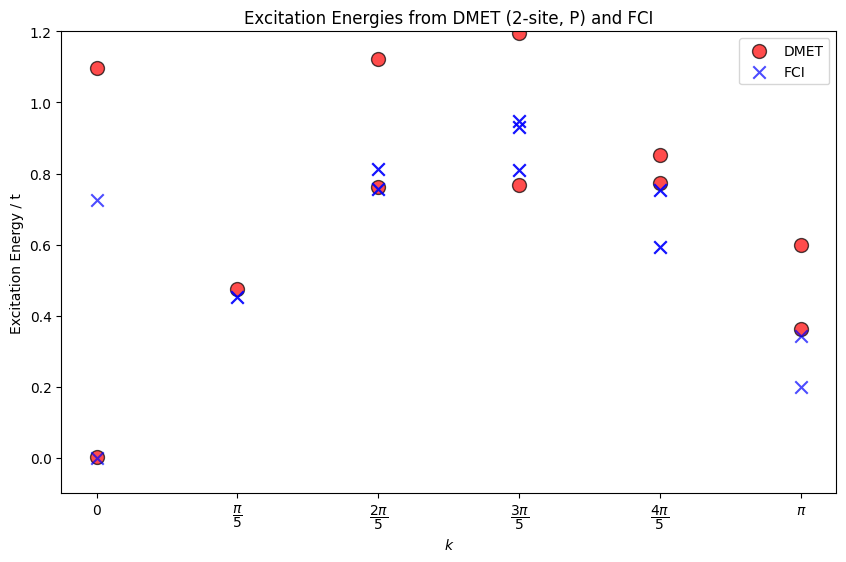

In [5]:
6# Plot the excitation energies from DMET and FCI
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(k_dmet, e_dmet, label='DMET', color='red',
            s=100, edgecolor='black', alpha=0.7)
plt.scatter(k_fci, e_fci, label='FCI', color='blue',
            s=80, marker='x', alpha=0.7
)
plt.title('Excitation Energies from DMET (2-site, P) and FCI')
plt.xlabel(r'$k$')
plt.xticks(np.linspace(0, np.pi, 6), 
           [r"$0$", r"$\dfrac{\pi}{5}$", r"$\dfrac{2\pi}{5}$",
            r"$\dfrac{3\pi}{5}$", r"$\dfrac{4\pi}{5}$", r"$\pi$"])
plt.ylabel('Excitation Energy / t')
plt.ylim(-0.1, 1.2)
plt.legend()
plt.show()